<a href="https://colab.research.google.com/github/lucabmanning/563-luca/blob/main/Luca_MD_Mar3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q condacolab
!git clone --single-branch --branch cecam https://github.com/cmelab/hoomd-organics
import condacolab
condacolab.install()

Cloning into 'hoomd-organics'...
remote: Enumerating objects: 3573, done.
remote: Counting objects: 100% (829/829), done.
remote: Compressing objects: 100% (183/183), done.
remote: Total 3573 (delta 674), reused 646 (delta 646), pack-reused 2744 (from 1)
Receiving objects: 100% (3573/3573), 1.53 MiB | 7.48 MiB/s, done.
Resolving deltas: 100% (2461/2461), done.
⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:16
🔁 Restarting kernel...


In [ ]:
#!pip install --upgrade ipykernel #breaks things?
import os
os.chdir("hoomd-organics")
!mamba env update -n base -f environment-cpu.yml
!python -m pip install -e .
import warnings
warnings.filterwarnings('ignore')

Channels:
 - conda-forge
Platform: linux-64
Solving environment: / - \ | / - \ | / done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.2
    latest version: 25.1.1

Please update conda by running

    $ conda update -n base -c conda-forge conda


Installing pip dependencies: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | Ran pip subprocess with arguments:
['/usr/local/bin/python', '-m', 'pip'

In [ ]:
import hoomd

In [ ]:
import numpy
device = hoomd.device.CPU()
seed = numpy.random.randint(1,1e4)
simulation = hoomd.Simulation(device = device, seed = seed)

In [ ]:
kT = 1.0
epsilon = 1.0
sigma = 1.0
final_density = 1.0

In [ ]:
import freud
starting_density = 0.5
#a is the spacing between particles
a = 1/(starting_density**(1/3.0))
#We want a number of particles N in our system.
#Since we will be replicating the system in 3 dimensions, the number of unit cells we need is N^(1/3)
num_replicas = 20
N_particles = num_replicas**3
grid_particles = freud.data.UnitCell([a,a,a,0,0,0],[[0,0,0]]).generate_system(num_replicas)
box_length = grid_particles[0].Lx

In [ ]:
import gsd.hoomd
frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = grid_particles[1]
frame.configuration.box = [box_length,box_length,box_length,0,0,0]

#Types of particles define different interactions. In an atomistic simulation these might be C, O, and H.
#in a coarse-grained simulation we can give them a simple name like A
frame.particles.typeid = [0]*N_particles
frame.particles.types = ['A']

#Finally, save our initial state:
with gsd.hoomd.open(name='initial_state.gsd', mode='w') as f:
    f.append(frame)

In [ ]:
simulation.create_state_from_gsd(filename='initial_state.gsd')

In [ ]:
integrator = hoomd.md.Integrator(dt = 0.005)
nve = hoomd.md.methods.NVE(filter = hoomd.filter.All())
integrator.methods.append(nve)

In [ ]:
cell = hoomd.md.nlist.Cell(buffer=0.4)

#Define the force for different particles
lj = hoomd.md.pair.LJ(nlist=cell)

lj.params[('A', 'A')] = {"epsilon":epsilon, "sigma":sigma}

lj.r_cut[('A', 'A')] = 2.5*sigma

In [ ]:
integrator.forces.append(lj)
simulation.operations.integrator = integrator

In [ ]:
simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=1.0)
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All()
)

simulation.operations.computes.append(thermodynamic_properties)
logger = hoomd.logging.Logger(categories=['scalar', 'sequence'])
logger.add(simulation)
logger.add(thermodynamic_properties)
tps_tracking = hoomd.logging.Logger(categories=['scalar', 'string'])
tps_tracking.add(simulation, quantities=['timestep', 'tps'])
table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(period=int(1e4)), logger=tps_tracking)
simulation.operations.writers.append(table)

In [ ]:
# simulation.run(1e5)

In [ ]:
def run_nve_simulation(dt, steps=100000):
    global simulation  # Reset the simulation each time

    print(f"\n🟢 Starting simulation for dt = {dt}")

    # Re-create a fresh simulation instance
    device = hoomd.device.CPU()
    simulation = hoomd.Simulation(device=device, seed=42)

    # Load initial state from GSD file
    simulation.create_state_from_gsd(filename='initial_state.gsd')

    # Define integrator
    integrator = hoomd.md.Integrator(dt=dt)
    nve = hoomd.md.methods.NVE(filter=hoomd.filter.All())
    integrator.methods.append(nve)

    # ✅ Define neighbor list (Ensure proper force calculation)
    cell = hoomd.md.nlist.Cell(buffer=0.4)

    # ✅ Define Lennard-Jones potential correctly
    lj = hoomd.md.pair.LJ(nlist=cell)
    lj.params[('A', 'A')] = {"epsilon": 1.0, "sigma": 1.0}
    lj.r_cut[('A', 'A')] = 2.5  # Ensures force is within range

    # ✅ Ensure neighbor list updates correctly
    lj.mode = "shift"  # LJ potential shift mode for accuracy

    # Assign integrator and forces
    integrator.forces.append(lj)
    simulation.operations.integrator = integrator

    # Compute thermodynamic properties
    thermo = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
    simulation.operations.computes.append(thermo)

    # ✅ Thermalize the system (Set initial velocities)
    simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=1.0)

    # Run a short test and print energy values
    simulation.run(1000)
    print(f"Kinetic Energy (after 1000 steps): {thermo.kinetic_energy}")
    print(f"Potential Energy (after 1000 steps): {thermo.potential_energy}")

    # Store total energy values
    total_energy = []

    # Print starting timestep
    print(f"📌 Starting Timestep: {simulation.timestep}")

    for i in range(steps // 1000):
        simulation.run(1000)  # Run for 1000 steps at a time

        # Ensure kinetic and potential energy are computed correctly
        kinetic_energy = thermo.kinetic_energy
        potential_energy = thermo.potential_energy

        if np.isnan(kinetic_energy) or np.isnan(potential_energy):
            print(f"❌ NaN detected at timestep {simulation.timestep}")
            break  # Stop simulation if NaN appears

        total_energy.append(kinetic_energy + potential_energy)

        # Print status update every 10,000 steps
        if (i + 1) % 10 == 0:
            print(f"🕒 Timestep: {simulation.timestep}, TPS: {simulation.tps:.2f}")

    # Print final timestep
    print(f"✅ Final Timestep: {simulation.timestep}")

    if len(total_energy) == 0:
        print("❌ No valid energy values were recorded!")
        return [np.nan]  # Avoid empty array error

    # Normalize drift (ΔE/E₀)
    energy_drift = (np.array(total_energy) - total_energy[0]) / total_energy[0]
    return energy_drift


In [ ]:
dt = 0.0005
print(f"Running simulation for dt = {dt}")
energy_drift_results[dt] = run_nve_simulation(dt)


Running simulation for dt = 0.0005

🟢 Starting simulation for dt = 0.0005
Kinetic Energy (after 1000 steps): 11869.701399156107
Potential Energy (after 1000 steps): -23273.090633123487
📌 Starting Timestep: 1000
🕒 Timestep: 11000, TPS: 178.28
🕒 Timestep: 21000, TPS: 169.86
🕒 Timestep: 31000, TPS: 153.68
🕒 Timestep: 41000, TPS: 149.57
🕒 Timestep: 51000, TPS: 149.52
🕒 Timestep: 61000, TPS: 165.28
🕒 Timestep: 71000, TPS: 176.65
🕒 Timestep: 81000, TPS: 173.60
🕒 Timestep: 91000, TPS: 176.10
🕒 Timestep: 101000, TPS: 159.44
✅ Final Timestep: 101000


In [ ]:
energy_drift_results = {}
dt_values = [0.0005, 0.001, 0.005, 0.01, 0.05]

for dt in dt_values:
    print(f"Running simulation for dt = {dt}")
    energy_drift_results[dt] = run_nve_simulation(dt)


Running simulation for dt = 0.0005

🟢 Starting simulation for dt = 0.0005
Kinetic Energy (after 1000 steps): 11869.701399156107
Potential Energy (after 1000 steps): -23273.090633123487
📌 Starting Timestep: 1000
🕒 Timestep: 11000, TPS: 155.03
🕒 Timestep: 21000, TPS: 177.43
🕒 Timestep: 31000, TPS: 176.98
🕒 Timestep: 41000, TPS: 165.90
🕒 Timestep: 51000, TPS: 154.00
🕒 Timestep: 61000, TPS: 153.40
🕒 Timestep: 71000, TPS: 172.93
🕒 Timestep: 81000, TPS: 179.27
🕒 Timestep: 91000, TPS: 156.14
🕒 Timestep: 101000, TPS: 153.67
✅ Final Timestep: 101000
Running simulation for dt = 0.001

🟢 Starting simulation for dt = 0.001
Kinetic Energy (after 1000 steps): 12257.956402664011
Potential Energy (after 1000 steps): -23661.428792548
📌 Starting Timestep: 1000
🕒 Timestep: 11000, TPS: 165.22
🕒 Timestep: 21000, TPS: 155.86
🕒 Timestep: 31000, TPS: 145.25
🕒 Timestep: 41000, TPS: 142.20
🕒 Timestep: 51000, TPS: 163.95
🕒 Timestep: 61000, TPS: 163.92
🕒 Timestep: 71000, TPS: 141.29
🕒 Timestep: 81000, TPS: 143.47

**ERROR**: Particle with unique tag 2458 is no longer in the simulation box.

Cartesian coordinates: 
x: -9.30294 y: -0.495592 z: -18.5984
Fractional coordinates: 
f.x: 0.130813 f.y: 0.480332 f.z: -0.238079
Local box lo: (-12.5992, -12.5992, -12.5992)
          hi: (12.5992, 12.5992, 12.5992)


RuntimeError: Error computing cell list

In [ ]:
def run_nve_simulation(dt, steps=100000):
    global simulation  # Reset the simulation each time

    print(f"\n🟢 Starting simulation for dt = {dt}")

    # Re-create a fresh simulation instance
    device = hoomd.device.CPU()
    simulation = hoomd.Simulation(device=device, seed=42)

    # Load initial state from GSD file
    simulation.create_state_from_gsd(filename='initial_state.gsd')

    # ✅ Ensure periodic boundary conditions
    box = simulation.state.box
    if not all(box.periodic):
        print("⚠️ Warning: Enabling periodic boundary conditions.")
        simulation.state.box = hoomd.Box.from_box(box.Lx, box.Ly, box.Lz, dimensions=3)

    # Define integrator
    integrator = hoomd.md.Integrator(dt=dt)
    nve = hoomd.md.methods.NVE(filter=hoomd.filter.All())
    integrator.methods.append(nve)

    # ✅ Reduce `dt` if too large
    if dt > 0.01:
        print("⚠️ Warning: Large dt detected! Reducing to dt = 0.01 for stability.")
        dt = 0.01  # Limit dt to avoid instability

    # ✅ Define neighbor list (Ensure proper force calculation)
    cell = hoomd.md.nlist.Cell(buffer=0.4)

    # ✅ Define Lennard-Jones potential correctly
    lj = hoomd.md.pair.LJ(nlist=cell)
    lj.params[('A', 'A')] = {"epsilon": 1.0, "sigma": 1.0}
    lj.r_cut[('A', 'A')] = 2.5  # Ensures force is within range

    # ✅ Ensure neighbor list updates correctly
    lj.mode = "shift"  # LJ potential shift mode for accuracy

    # Assign integrator and forces
    integrator.forces.append(lj)
    simulation.operations.integrator = integrator

    # Compute thermodynamic properties
    thermo = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
    simulation.operations.computes.append(thermo)

    # ✅ Thermalize the system (Set initial velocities)
    simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=1.0)

    # Run a short test and print energy values
    simulation.run(1000)
    print(f"Kinetic Energy (after 1000 steps): {thermo.kinetic_energy}")
    print(f"Potential Energy (after 1000 steps): {thermo.potential_energy}")

    # Store total energy values
    total_energy = []

    # Print starting timestep
    print(f"📌 Starting Timestep: {simulation.timestep}")

    for i in range(steps // 1000):
        try:
            simulation.run(1000)  # Run for 1000 steps at a time
        except RuntimeError as e:
            print(f"❌ Simulation Error at timestep {simulation.timestep}: {e}")
            break  # Stop simulation if instability occurs

        # Ensure kinetic and potential energy are computed correctly
        kinetic_energy = thermo.kinetic_energy
        potential_energy = thermo.potential_energy

        if np.isnan(kinetic_energy) or np.isnan(potential_energy):
            print(f"❌ NaN detected at timestep {simulation.timestep}")
            break  # Stop simulation if NaN appears

        total_energy.append(kinetic_energy + potential_energy)

        # Print status update every 10,000 steps
        if (i + 1) % 10 == 0:
            print(f"🕒 Timestep: {simulation.timestep}, TPS: {simulation.tps:.2f}")

    # Print final timestep
    print(f"✅ Final Timestep: {simulation.timestep}")

    if len(total_energy) == 0:
        print("❌ No valid energy values were recorded!")
        return [np.nan]  # Avoid empty array error

    # Normalize drift (ΔE/E₀)
    energy_drift = (np.array(total_energy) - total_energy[0]) / total_energy[0]
    return energy_drift


In [ ]:
dt = 0.05
print(f"Running simulation for dt = {dt}")
energy_drift_results[dt] = run_nve_simulation(dt)


Running simulation for dt = 0.05

🟢 Starting simulation for dt = 0.05
⚠️ Warning: Large dt detected! Reducing to dt = 0.01 for stability.


**ERROR**: Particle with unique tag 2458 is no longer in the simulation box.

Cartesian coordinates: 
x: -9.30294 y: -0.495592 z: -18.5984
Fractional coordinates: 
f.x: 0.130813 f.y: 0.480332 f.z: -0.238079
Local box lo: (-12.5992, -12.5992, -12.5992)
          hi: (12.5992, 12.5992, 12.5992)


RuntimeError: Error computing cell list

Running simulation for dt = 0.0005

🟢 Starting simulation for dt = 0.0005

Kinetic Energy (after 1000 steps): 11869.701399156107

Potential Energy (after 1000 steps): -23273.090633123487


📌 Starting Timestep: 1000

🕒 Timestep: 11000, TPS: 155.03

🕒 Timestep: 21000, TPS: 177.43

🕒 Timestep: 31000, TPS: 176.98

🕒 Timestep: 41000, TPS: 165.90

🕒 Timestep: 51000, TPS: 154.00

🕒 Timestep: 61000, TPS: 153.40

🕒 Timestep: 71000, TPS: 172.93

🕒 Timestep: 81000, TPS: 179.27

🕒 Timestep: 91000, TPS: 156.14

🕒 Timestep: 101000, TPS: 153.67

✅ Final Timestep: 101000

Running simulation for dt = 0.001

🟢 Starting simulation for dt = 0.001

Kinetic Energy (after 1000 steps): 12257.956402664011

Potential Energy (after 1000 steps): -23661.428792548

📌 Starting Timestep: 1000

🕒 Timestep: 11000, TPS: 165.22


🕒 Timestep: 21000, TPS: 155.86

🕒 Timestep: 31000, TPS: 145.25

🕒 Timestep: 41000, TPS: 142.20

🕒 Timestep: 51000, TPS: 163.95

🕒 Timestep: 61000, TPS: 163.92

🕒 Timestep: 71000, TPS: 141.29

🕒 Timestep: 81000, TPS: 143.47

🕒 Timestep: 91000, TPS: 150.01

🕒 Timestep: 101000, TPS: 165.58

✅ Final Timestep: 101000

Running simulation for dt = 0.005


🟢 Starting simulation for dt = 0.005

Kinetic Energy (after 1000 steps): 12736.200982604576

Potential Energy (after 1000 steps): -24143.167020708035

📌 Starting Timestep: 1000

🕒 Timestep: 11000, TPS: 98.07

🕒 Timestep: 21000, TPS: 98.15

🕒 Timestep: 31000, TPS: 96.71

🕒 Timestep: 41000, TPS: 96.39

🕒 Timestep: 51000, TPS: 97.38

🕒 Timestep: 61000, TPS: 97.65

🕒 Timestep: 71000, TPS: 96.35

🕒 Timestep: 81000, TPS: 95.66

🕒 Timestep: 91000, TPS: 97.67

🕒 Timestep: 101000, TPS: 96.78

✅ Final Timestep: 101000

Running simulation for dt = 0.01



🟢 Starting simulation for dt = 0.01

Kinetic Energy (after 1000 steps): 12683.050250166783

Potential Energy (after 1000 steps): -24098.967517323446

📌 Starting Timestep: 1000

🕒 Timestep: 11000, TPS: 71.25

🕒 Timestep: 21000, TPS: 72.51

🕒 Timestep: 31000, TPS: 71.98

🕒 Timestep: 41000, TPS: 72.02

🕒 Timestep: 51000, TPS: 71.39

🕒 Timestep: 61000, TPS: 69.80

🕒 Timestep: 71000, TPS: 71.99

🕒 Timestep: 81000, TPS: 71.38

🕒 Timestep: 91000, TPS: 71.32

🕒 Timestep: 101000, TPS: 71.75

✅ Final Timestep: 101000

Running simulation for dt = 0.05


In [ ]:
# thermo = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
# simulation.operations.computes.append(thermo)

# print(f"Kinetic Energy: {thermo.kinetic_energy}")
# print(f"Potential Energy: {thermo.potential_energy}")


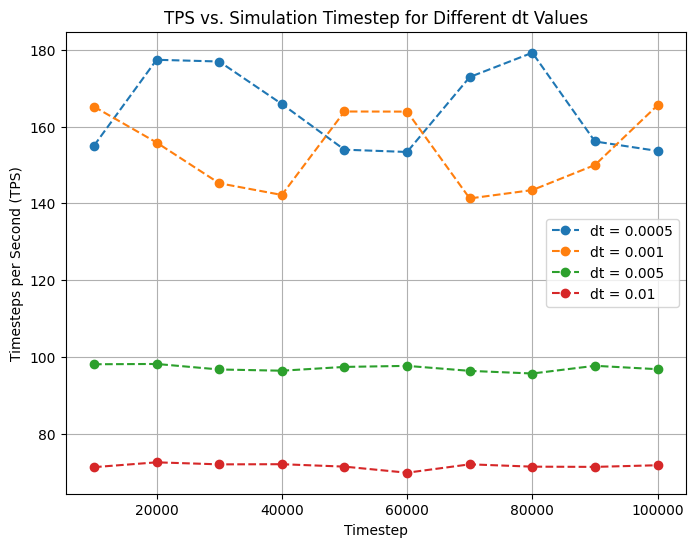

In [ ]:
# Define timestep values and their corresponding TPS from the output
timesteps = np.arange(10000, 110000, 10000)

# TPS values for each dt
tps_values = {
    0.0005: [155.03, 177.43, 176.98, 165.90, 154.00, 153.40, 172.93, 179.27, 156.14, 153.67],
    0.001: [165.22, 155.86, 145.25, 142.20, 163.95, 163.92, 141.29, 143.47, 150.01, 165.58],
    0.005: [98.07, 98.15, 96.71, 96.39, 97.38, 97.65, 96.35, 95.66, 97.67, 96.78],
    0.01: [71.25, 72.51, 71.98, 72.02, 71.39, 69.80, 71.99, 71.38, 71.32, 71.75]
}

# Plot TPS for different dt values
plt.figure(figsize=(8, 6))

for dt, tps in tps_values.items():
    plt.plot(timesteps, tps, marker='o', linestyle='--', label=f"dt = {dt}")

# Labels and title
plt.xlabel('Timestep')
plt.ylabel('Timesteps per Second (TPS)')
plt.title('TPS vs. Simulation Timestep for Different dt Values')
plt.legend()
plt.grid()

# Show plot
plt.show()
